In [2]:
!pip install findspark



Defaulting to user installation because normal site-packages is not writeable


In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BotFailureClustering").getOrCreate()
sc = spark.sparkContext

In [7]:
# Step 2: Load Dataset
df = spark.read.csv("C:\\Users\\jagadeesh02.TRN\\Desktop\\Project Details\\trading_bot_dataset_with_user_profiles.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- Interaction ID: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- User Query: string (nullable = true)
 |-- Intent Detected: string (nullable = true)
 |-- Bot Response: string (nullable = true)
 |-- Response Time (ms): integer (nullable = true)
 |-- Prediction Accuracy (%): integer (nullable = true)
 |-- Entity Extraction Accuracy (%): integer (nullable = true)
 |-- User Sentiment: string (nullable = true)
 |-- User Feedback: string (nullable = true)
 |-- Conversation Success: string (nullable = true)
 |-- User ID: string (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Device Type: string (nullable = true)
 |-- Account Age (months): integer (nullable = true)
 |-- Is Premium: boolean (nullable = true)

+--------------+-------------------+--------------------+----------------+--------------------+------------------+-----------------------+------------------------------+--------------+----------------

In [8]:
from pyspark.sql.functions import col, when

# Convert 'Conversation Success' to binary: Successful = 1, Failed = 0
# Convert 'User Sentiment' to numerical score: Positive = 1, Neutral = 0, Negative = -1
df_clean = df.withColumn(
    "Conversation_Success_Bin",
    when(col("Conversation Success") == "Successful", 1).otherwise(0)
).withColumn(
    "Sentiment_Score",
    when(col("User Sentiment") == "Positive", 1)
    .when(col("User Sentiment") == "Neutral", 0)
    .when(col("User Sentiment") == "Negative", -1)
    .otherwise(None)
)

# Drop rows where any key feature is missing
df_clean = df_clean.dropna(subset=[
    "Response Time (ms)",
    "Prediction Accuracy (%)",
    "Entity Extraction Accuracy (%)",
    "Sentiment_Score",
    "Conversation_Success_Bin"
])

df_clean.show(5)


+--------------+-------------------+--------------------+----------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+------------------------+---------------+
|Interaction ID|          Timestamp|          User Query| Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium|Conversation_Success_Bin|Sentiment_Score|
+--------------+-------------------+--------------------+----------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-------

In [9]:
# Step 4: Assemble Features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "Response Time (ms)", 
        "Prediction Accuracy (%)", 
        "Entity Extraction Accuracy (%)", 
        "Sentiment_Score", 
        "Conversation_Success_Bin"
    ],
    outputCol="features"
)

assembled_df = assembler.transform(df_clean)
assembled_df.show()


+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+------------------------+---------------+--------------------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium|Conversation_Success_Bin|Sentiment_Score|            features|
+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-----------

In [10]:
# Step 5: KMeans Clustering
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=42, featuresCol="features")
model = kmeans.fit(assembled_df)
clustered = model.transform(assembled_df)
clustered.show()


+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+------------------------+---------------+--------------------+----------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium|Conversation_Success_Bin|Sentiment_Score|            features|prediction|
+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+---

In [11]:
# Step 6: Inspect Clusters
clustered.select(
    "Interaction ID", "User ID", "Response Time (ms)", 
    "Prediction Accuracy (%)", "Entity Extraction Accuracy (%)", 
    "User Sentiment", "Conversation Success", "prediction"
).show(10)


+--------------+-------+------------------+-----------------------+------------------------------+--------------+--------------------+----------+
|Interaction ID|User ID|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|Conversation Success|prediction|
+--------------+-------+------------------+-----------------------+------------------------------+--------------+--------------------+----------+
|             1| U10166|               150|                     95|                            90|       Neutral|              Failed|         1|
|             2| U10030|               155|                     94|                            91|      Positive|          Successful|         3|
|             3| U10253|               160|                     93|                            92|      Positive|          Successful|         3|
|             4| U10255|               165|                     92|                            93|      Positive|          S

In [12]:
# Step 7: Grouping and Analysis
from pyspark.sql.functions import count, avg

clustered.groupBy("prediction").agg(
    count("*").alias("interaction_count"),
    avg("Response Time (ms)").alias("avg_response_time"),
    avg("Prediction Accuracy (%)").alias("avg_prediction_accuracy"),
    avg("Entity Extraction Accuracy (%)").alias("avg_entity_accuracy"),
    avg("Conversation_Success_Bin").alias("success_rate")
).orderBy("interaction_count", ascending=False).show()


+----------+-----------------+-----------------+-----------------------+-------------------+------------------+
|prediction|interaction_count|avg_response_time|avg_prediction_accuracy|avg_entity_accuracy|      success_rate|
+----------+-----------------+-----------------+-----------------------+-------------------+------------------+
|         0|              400|            187.5|                   87.5|               92.5|             0.625|
|         2|              300|            170.0|                   91.0|  92.33333333333333|0.5933333333333334|
|         3|              200|            157.5|                   93.5|               91.5|             0.575|
|         1|              100|            150.0|                   95.0|               90.0|              0.57|
+----------+-----------------+-----------------+-----------------------+-------------------+------------------+



In [13]:
# Step 8: Cluster Centers for Interpretation
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i} center: {center}")


Cluster 0 center: [187.5    87.5    92.5     0.33    0.625]
Cluster 1 center: [150.    95.    90.     0.23   0.57]
Cluster 2 center: [170.          91.          92.33333333   0.29666667   0.59333333]
Cluster 3 center: [157.5    93.5    91.5     0.28    0.575]


In [15]:
!pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------- ------- 6.6/8.1 MB 32.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 20.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 13.4 MB/s eta 0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   ----- ---------------------------------- 1/8 [pillow]
   -

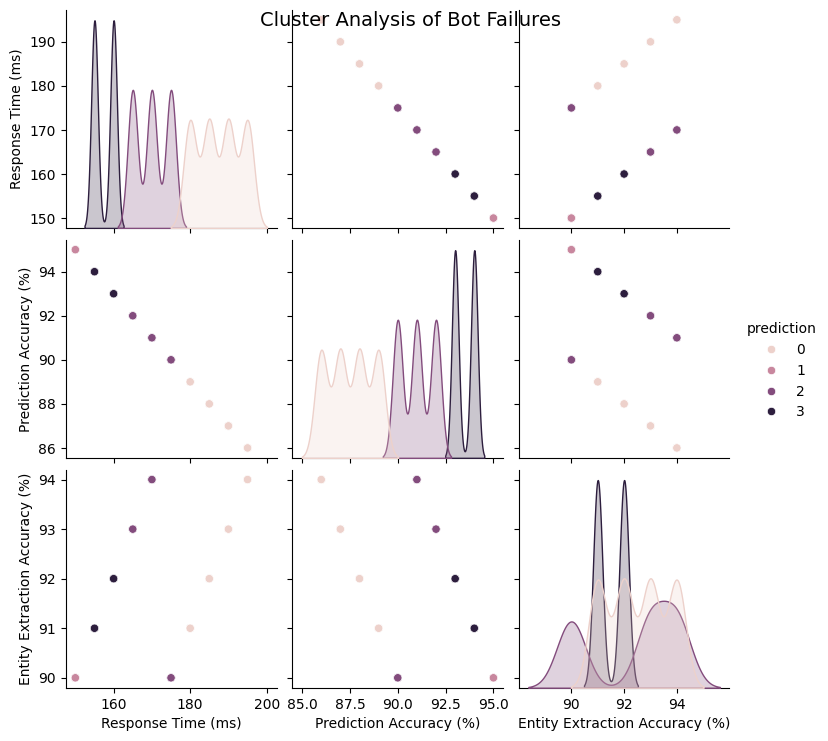

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = clustered.select(
    "prediction", 
    "Response Time (ms)", 
    "Prediction Accuracy (%)", 
    "Entity Extraction Accuracy (%)"
).toPandas()

sns.pairplot(pandas_df, hue="prediction", diag_kind="kde")
plt.suptitle("Cluster Analysis of Bot Failures", fontsize=14)
plt.show()


PCA for Cluster Visualization(2D)


In [20]:
from pyspark.sql.functions import col, when

# Check distinct values in 'Conversation Success'
df.select("Conversation Success").distinct().show()

# Create error_type column (case-sensitive matching)
df = df.withColumn("error_type", when(col("Conversation Success") == "Failed", "Bot Failure")
                                  .otherwise("No Error"))

# Check the error_type column
df.select("Conversation Success", "error_type").show(10)

# Fill any nulls in error_type (if any)
df = df.fillna({'error_type': 'unknown'})

# Then apply StringIndexer
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="error_type", outputCol="error_type_index1")
df = indexer.fit(df).transform(df)


+--------------------+
|Conversation Success|
+--------------------+
|              Failed|
|          Successful|
+--------------------+

+--------------------+-----------+
|Conversation Success| error_type|
+--------------------+-----------+
|              Failed|Bot Failure|
|          Successful|   No Error|
|          Successful|   No Error|
|          Successful|   No Error|
|          Successful|   No Error|
|          Successful|   No Error|
|          Successful|   No Error|
|              Failed|Bot Failure|
|          Successful|   No Error|
|          Successful|   No Error|
+--------------------+-----------+
only showing top 10 rows



In [21]:
# 📦 Required libraries
from pyspark.ml.feature import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Apply PCA to reduce features to 2 dimensions
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)           # replaced final_df with assembled_df
pca_result = pca_model.transform(assembled_df)
pca_result.show()


+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+------------------------+---------------+--------------------+--------------------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium|Conversation_Success_Bin|Sentiment_Score|            features|        pca_features|
+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+------------

In [27]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
from pyspark.sql.functions import when, col

# Starting from your original df

# Step 1: Create error_type column
df = df.withColumn("error_type", when(col("Conversation Success") == "Failed", "Bot Failure").otherwise("No Error"))

# Step 2: Index error_type
indexer = StringIndexer(inputCol="error_type", outputCol="error_type_index2")
df = indexer.fit(df).transform(df)

# Step 3: Assemble features including error_type_index1 and any other numeric columns
feature_cols = ["Response Time (ms)", "error_type_index1"]  # example features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df)

# Step 4: Run PCA on assembled_df
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
pca_result = pca_model.transform(assembled_df)

# Step 5: Now select pca_features and error_type_index1 from pca_result
pdf = pca_result.select("pca_features", "error_type_index2").toPandas()

# Step 6: Expand PCA features into separate columns for plotting
pdf[['x', 'y']] = pd.DataFrame(pdf['pca_features'].tolist(), index=pdf.index)


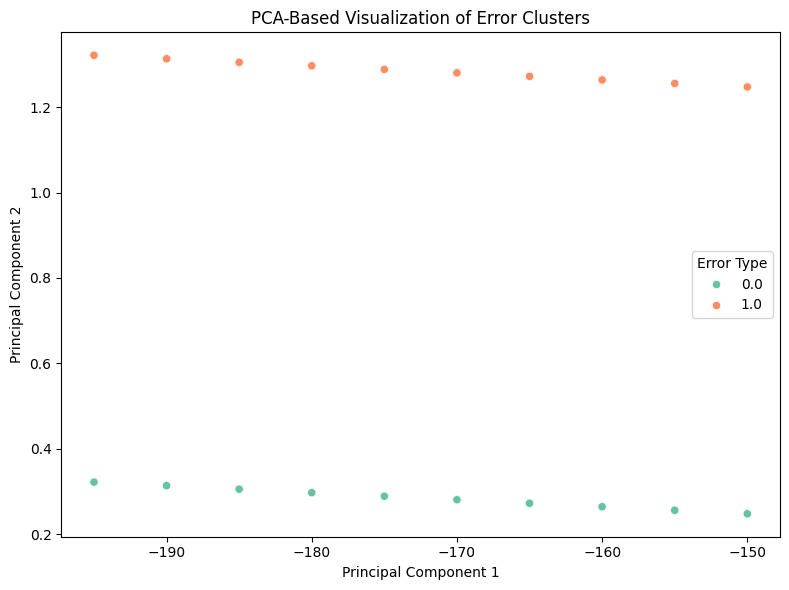

In [30]:
# 📈 Scatter plot to visualize clusters in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pdf, x="x", y="y", hue="error_type_index2", palette="Set2")
plt.title("PCA-Based Visualization of Error Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Error Type")
plt.tight_layout()
plt.show()

Elbow Method (WSSSE)


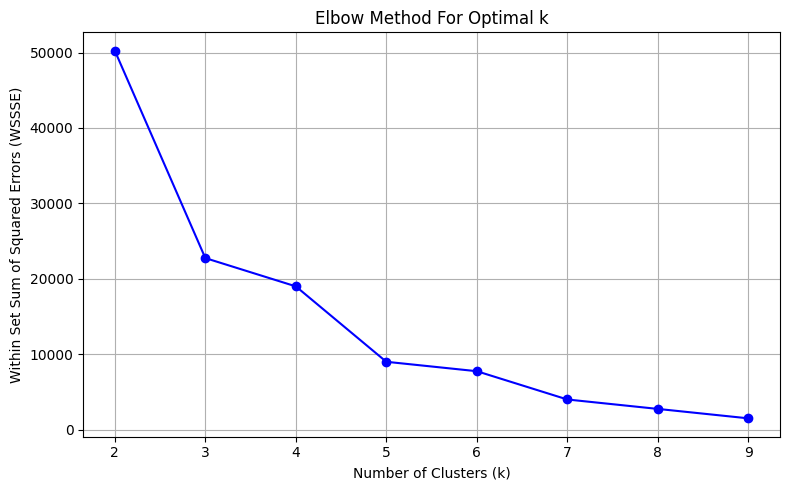

In [31]:
#The Elbow Method is a popular technique used to determine the optimal number of clusters (k) in 
# clustering algorithms like K-Means.
# 📦 Required libraries
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# 🔢 Try different values of k
ks = list(range(2, 10))
wssse = []

# 📊 Compute Within Set Sum of Squared Errors (WSSSE)
for k in ks:
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(final_df)
    wssse.append(model.summary.trainingCost)

# 📈 Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(ks, wssse, marker='o', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


Silhouette Score Plot

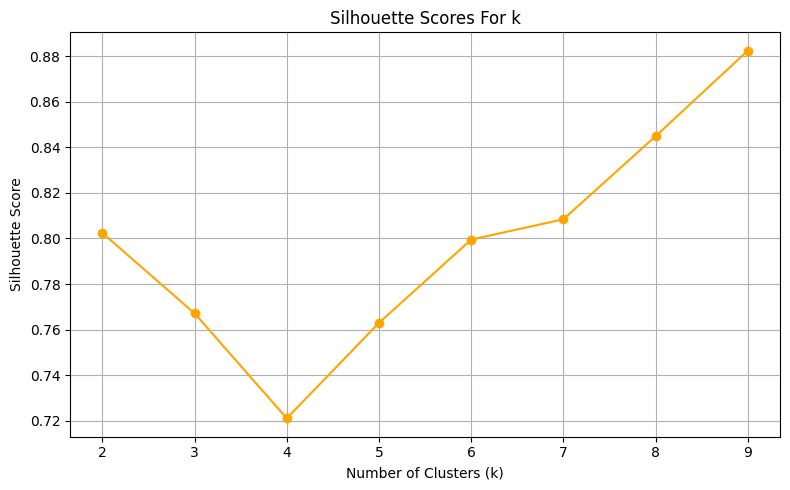

In [32]:
#The Silhouette Score is a metric used to evaluate the quality of clusters created by 
# a clustering algorithm, such as K-Means. It measures how well each data point fits 
# within its assigned cluster compared to other clusters.

# 📦 Required libraries
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# 🔢 Try different values of k
ks = list(range(2, 10))
silhouette_scores = []

# 📈 Compute silhouette score for each k
for k in ks:
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(final_df)
    predictions = model.transform(final_df)

    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

# 📈 Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(ks, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For k')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# 🏆 Find the best k based on the highest silhouette score
best_k = ks[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k based on silhouette score: {best_k}")


Best k based on silhouette score: 9


Clustering Profiling

In [36]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=best_k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled_df)
clustered_df = model.transform(assembled_df)
clustered_df.show()


+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-----------+----------------+-----------------+-----------------+-----------+-------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium| error_type|error_type_index|error_type_index1|error_type_index2|   features|cluster|
+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------

In [41]:
# Get columns from df except join key
df_cols_to_keep = [c for c in df.columns if c != "Interaction ID"]

# Select only necessary columns in df before join
df_trimmed = df.select(["Interaction ID"] + df_cols_to_keep)

# Now join, no duplicate columns except "Interaction ID"
enriched_df = clustered_df.join(df_trimmed, on="Interaction ID", how="left")


In [42]:
#Join Cluster Labels with Original Data
#This allows interpreting what kind of data is in each cluster.
enriched_df = clustered_df.join(df, on="Interaction ID", how="left")
enriched_df.show()

+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-----------+----------------+-----------------+-----------------+-----------+-------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-----------+----------------+-----------------+-----------------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|  

In [43]:
# Suppose 'Prediction Accuracy (%)' is duplicated, drop the extra one from enriched_df
enriched_df = enriched_df.drop(df["Prediction Accuracy (%)"])  # drop from right side df


In [44]:
# Rename columns in df to avoid conflicts
df_renamed = df.select(
    col("Interaction ID"),
    col("Response Time (ms)").alias("Response Time (ms)_df"),
    col("Prediction Accuracy (%)").alias("Prediction Accuracy (%)_df"),
    # Rename other columns as needed
)

# Now join
enriched_df = clustered_df.join(df_renamed, on="Interaction ID", how="left")


In [46]:
enriched_df.show()


+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-----------+----------------+-----------------+-----------------+-----------+-------+---------------------+--------------------------+
|Interaction ID|          Timestamp|          User Query|     Intent Detected|        Bot Response|Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|    User Feedback|Conversation Success|User ID|    User Type|       Region|Device Type|Account Age (months)|Is Premium| error_type|error_type_index|error_type_index1|error_type_index2|   features|cluster|Response Time (ms)_df|Prediction Accuracy (%)_df|
+--------------+-------------------+--------------------+--------------------+--------------------+-----------------

In [49]:
print(enriched_df.columns)


['Interaction ID', 'Timestamp', 'User Query', 'Intent Detected', 'Bot Response', 'Response Time (ms)', 'Prediction Accuracy (%)', 'Entity Extraction Accuracy (%)', 'User Sentiment', 'User Feedback', 'Conversation Success', 'User ID', 'User Type', 'Region', 'Device Type', 'Account Age (months)', 'Is Premium', 'error_type', 'error_type_index', 'error_type_index1', 'error_type_index2', 'features', 'cluster', 'Response Time (ms)_df', 'Prediction Accuracy (%)_df']


In [50]:
df_clean = enriched_df.select(
    col("cluster"),
    col("`Response Time (ms)_df`").alias("response_time"),
    col("`Prediction Accuracy (%)_df`").alias("prediction_accuracy"),
    col("`Entity Extraction Accuracy (%)`").alias("entity_accuracy")
)


In [51]:
from pyspark.sql.functions import avg

cluster_summary = df_clean.groupBy("cluster").agg(
    avg("response_time").alias("avg_response_time"),
    avg("prediction_accuracy").alias("avg_prediction_accuracy"),
    avg("entity_accuracy").alias("avg_entity_accuracy")
)

cluster_summary.show(truncate=False)


+-------+-----------------+-----------------------+-------------------+
|cluster|avg_response_time|avg_prediction_accuracy|avg_entity_accuracy|
+-------+-----------------+-----------------------+-------------------+
|1      |185.0            |88.0                   |92.0               |
|6      |190.0            |87.0                   |93.0               |
|3      |155.0            |94.0                   |91.0               |
|5      |180.0            |89.0                   |91.0               |
|4      |195.0            |86.0                   |94.0               |
|8      |160.0            |93.0                   |92.0               |
|7      |165.0            |92.0                   |93.0               |
|2      |172.5            |90.5                   |92.0               |
|0      |150.0            |95.0                   |90.0               |
+-------+-----------------+-----------------------+-------------------+



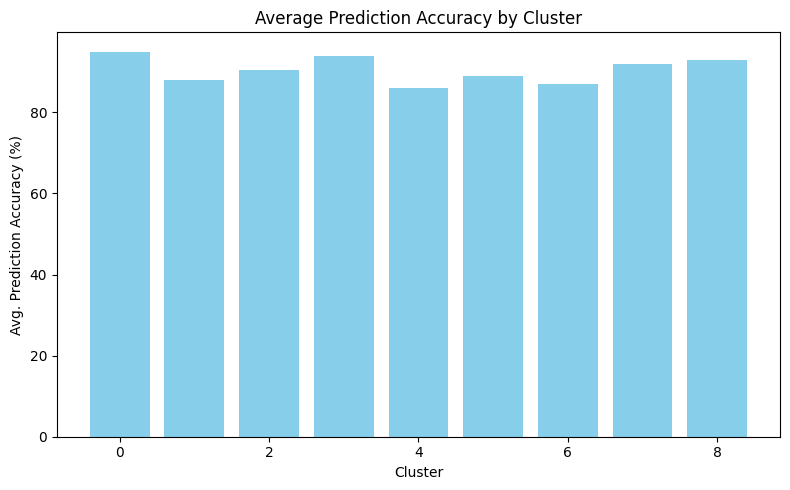

In [52]:
# 📊 Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

# 🐼 Convert Spark DataFrame to Pandas for plotting
summary_pdf = cluster_summary.toPandas()

# 📉 Create a bar chart showing average prediction accuracy for each cluster
plt.figure(figsize=(8, 5))  # Set figure size (width, height)

# Create a bar chart with cluster on x-axis and prediction accuracy on y-axis
plt.bar(summary_pdf['cluster'], summary_pdf['avg_prediction_accuracy'], color='skyblue')

# 🏷️ Add axis labels and title
plt.xlabel("Cluster")  # Label for x-axis
plt.ylabel("Avg. Prediction Accuracy (%)")  # Label for y-axis
plt.title("Average Prediction Accuracy by Cluster")  # Chart title

# 🔧 Adjust layout for better spacing
plt.tight_layout()

# 📺 Display the plot
plt.show()


In [53]:
# 🔍 Show sample rows that belong to Cluster 0
# This helps inspect what kind of data points are grouped into this cluster
enriched_df.filter(col("cluster") == 0).show(5, truncate=False)


+--------------+-------------------+----------------------------------+-----------------+-----------------------------------+------------------+-----------------------+------------------------------+--------------+-----------------+--------------------+-------+-------------+-------------+-----------+--------------------+----------+-----------+----------------+-----------------+-----------------+-----------+-------+---------------------+--------------------------+
|Interaction ID|Timestamp          |User Query                        |Intent Detected  |Bot Response                       |Response Time (ms)|Prediction Accuracy (%)|Entity Extraction Accuracy (%)|User Sentiment|User Feedback    |Conversation Success|User ID|User Type    |Region       |Device Type|Account Age (months)|Is Premium|error_type |error_type_index|error_type_index1|error_type_index2|features   |cluster|Response Time (ms)_df|Prediction Accuracy (%)_df|
+--------------+-------------------+----------------------------